In [1]:
import numpy as np
import pandas as pd
import datetime
from pandas import Grouper
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
db = pd.read_csv('db.csv', 
                         sep=';',
                         on_bad_lines='skip',
                         names=["TICKER", "DATE", "SIGN", "ROBERTA", "VADERS", "ADJ_CLOSE", "HIGH", "VOLUME", "ADJ_CLOSE_NORM", "HIGH_NORM", "VOLUME_NORM"],
                         skiprows=1)

#db['DATE'] = pd.to_datetime(db['DATE'], format='%Y-%M-%d')
db['DATE'] = pd.to_datetime(db['DATE'], errors='coerce')

df = db.reset_index()

In [3]:
db = df
db = db[db['DATE'].dt.date>=datetime.date(2016,9,1)]

In [4]:
dict_df = {(ticker, date): adj_close for ticker, date, adj_close in zip(db['TICKER'], db['DATE'].dt.strftime('%Y-%m-%d'), db['ADJ_CLOSE_NORM'])}
dict_df

{('A', '2013-12-02'): nan,
 ('A', '2013-12-03'): 0.2212335642560541,
 ('A', '2013-12-04'): 0.5063898671524416,
 ('A', '2013-12-05'): 0.2825032090564532,
 ('A', '2013-12-06'): 0.710864714883999,
 ('A', '2013-12-09'): 0.3749526603317872,
 ('A', '2013-12-10'): 0.3894435314616222,
 ('A', '2013-12-11'): 0.1599059664580315,
 ('A', '2013-12-12'): 0.4312653757105782,
 ('A', '2013-12-13'): 0.2773568095884149,
 ('A', '2013-12-16'): 0.3303510956279101,
 ('A', '2013-12-17'): 0.6392807079636171,
 ('A', '2013-12-18'): 0.7450825218843042,
 ('A', '2013-12-19'): 0.1635699986804581,
 ('A', '2013-12-20'): 0.1877948029576699,
 ('A', '2013-12-23'): 0.4722896899238238,
 ('A', '2013-12-24'): 0.2191971140235715,
 ('A', '2013-12-26'): 0.3721014492113381,
 ('A', '2013-12-27'): 0.2768406245785242,
 ('A', '2013-12-30'): 0.3494239071970206,
 ('A', '2013-12-31'): 0.2699027205358335,
 ('A', '2014-01-02'): 0.0282371412482533,
 ('A', '2014-01-03'): 0.5120899359792466,
 ('A', '2014-01-06'): 0.2268102631402317,
 ('A', '

In [6]:
quantiles_plus = db.groupby('TICKER').ADJ_CLOSE_NORM.quantile(0.80).to_dict()
quantiles_minus = db.groupby('TICKER').ADJ_CLOSE_NORM.quantile(0.10).to_dict()

dict_df = {(ticker, date): adj_close for ticker, date, adj_close in zip(db['TICKER'], db['DATE'].dt.strftime('%Y-%m-%d'), db['ADJ_CLOSE_NORM'])}

def check_trend(row):
    if abs(row['ROBERTA']) < 0.7:
        return None

    ticker = row['TICKER']
    date = row['DATE']
    next_five_days = pd.date_range(date, periods=6).strftime('%Y-%m-%d').tolist()[1:]
    
    tresholdplus = quantiles_plus[ticker]
    tresholdminus = quantiles_minus[ticker]

    next_days_values = []
    for next_day in next_five_days:
        val = dict_df.get((ticker, next_day))
        if val is not None:
            next_days_values.append(val)

    if row['ROBERTA'] > 0.7:
        if any(value > tresholdplus for value in next_days_values):
            return 1
        else:
            return 0
    elif row['ROBERTA'] < -0.7:
        if any(value < tresholdminus for value in next_days_values):
            return 1
        else:
            return 0
    else:
        return 0

db['TREND_CORRECT'] = db.apply(check_trend, axis=1)

In [10]:
db = db.dropna()

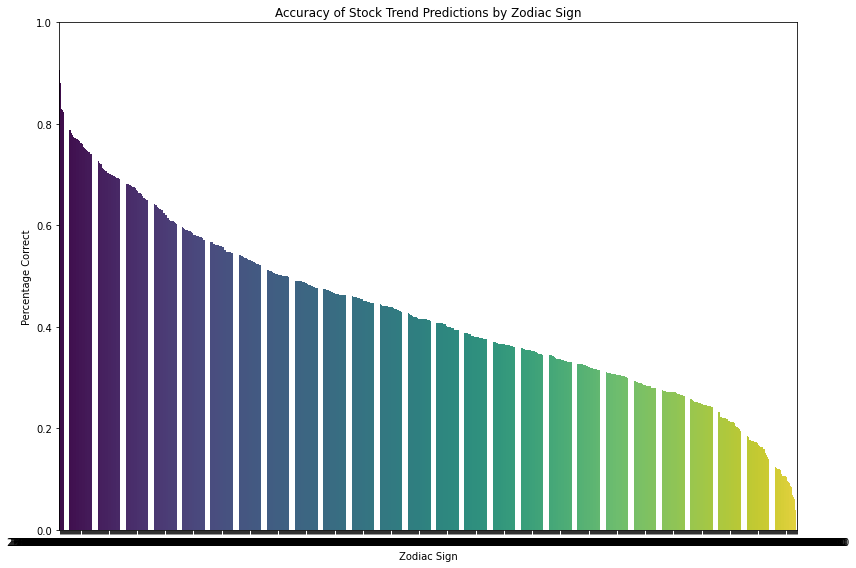

In [11]:
grouped = db.groupby('DATE')['TREND_CORRECT'].mean().reset_index()

# Sort the values (optional, but can make the visualization more informative)
grouped = grouped.sort_values('TREND_CORRECT', ascending=False)

# Create the bar chart
plt.figure(figsize=(12,8))
sns.barplot(x='DATE', y='TREND_CORRECT', data=grouped, palette='viridis')
plt.title('Accuracy of Stock Trend Predictions by Zodiac Sign')
plt.ylabel('Percentage Correct')
plt.xlabel('Zodiac Sign')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 since we're working with percentages

# Display the chart
plt.tight_layout()
plt.show()

In [12]:
db['MONTH'] = db['DATE'].dt.to_period('M').astype(str)
grouped = db.groupby('MONTH')['TREND_CORRECT'].mean().reset_index()

# Create a line chart with Plotly
fig = px.line(grouped, x='MONTH', y='TREND_CORRECT', title='Accuracy of Stock Trend Predictions Over Time')

# Add axis labels
fig.update_layout(xaxis_title='Date (by month)', yaxis_title='Percentage Correct', yaxis_tickformat='%')

# Show the plot
fig.show()

In [13]:
db.TREND_CORRECT.value_counts()

TREND_CORRECT
0.0    515099
1.0    412105
Name: count, dtype: int64

In [18]:
def compute_scores(interval):
    df2 = db.groupby(['TICKER', pd.Grouper(key='DATE', axis=0, freq=f'{interval}D')])\
            .agg({'ADJ_CLOSE':'mean', 'ROBERTA':'mean', 'VADERS':'mean', 'SIGN':'max'}).reset_index()
    
    df2['VADERS_CORRECT'] = np.where(df2['VADERS']*df2['ADJ_CLOSE'] > 0, 1, 0)
    df2['ROBERTA_CORRECT'] = np.where(df2['ROBERTA']*df2['ADJ_CLOSE'] > 0, 1, 0)
    
    sign_scores = df2.groupby('SIGN').agg({'VADERS_CORRECT':'sum', 'ROBERTA_CORRECT':'sum', 'DATE':'count'})
    sign_scores['VADERS_SCORE'] = sign_scores['VADERS_CORRECT']/sign_scores['DATE']
    sign_scores['ROBERTA_SCORE'] = sign_scores['ROBERTA_CORRECT']/sign_scores['DATE']
    
    return sign_scores['VADERS_SCORE'].mean(), sign_scores['ROBERTA_SCORE'].mean()


In [19]:
intervals = list(range(1, 31))
vaders_scores = []
roberta_scores = []

for interval in intervals:
    v_score, r_score = compute_scores(interval)
    vaders_scores.append(v_score)
    roberta_scores.append(r_score)

# Plotting
plt.figure(figsize=(14,7))
plt.plot(intervals, vaders_scores, label='Vaders', marker='o')
plt.plot(intervals, roberta_scores, label='Roberta', marker='o')
plt.xlabel("Grouping Interval (days)")
plt.ylabel("Average Proportion Correct")
plt.title("Accuracy Trend as Grouping Interval Changes")
plt.legend()
plt.grid(True)
plt.show()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [2]:
df = pd.read_csv('db.csv', 
                         sep=';',
                         on_bad_lines='skip',
                         names=["TICKER", "DATE", "SIGN", "ROBERTA", "VADERS", "ADJ_CLOSE", "HIGH", "VOLUME"],
                         skiprows=1)

#db['DATE'] = pd.to_datetime(db['DATE'], format='%Y-%M-%d')
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df.describe()

,DATE,ROBERTA,VADERS,ADJ_CLOSE,HIGH,VOLUME
count,3499765,3.417296e+06,3.417296e+06,3.494601e+06,3.494601e+06,3.494601e+06
mean,2015-06-26 08:33:27.963849472,1.396295e-01,2.971286e-01,3.098720e+01,3.064644e+01,4.880863e+02
min,2013-12-02 00:00:00,-9.529028e-01,-9.807000e-01,-9.999856e+01,-9.999858e+01,-9.999960e+01
25%,2014-09-26 00:00:00,-3.205281e-01,-1.280000e-01,-9.554286e-01,-8.750782e-01,-3.100297e+01
50%,2015-07-06 00:00:00,1.209428e-01,4.678000e-01,0.000000e+00,0.000000e+00,-1.404125e+00
75%,2016-03-31 00:00:00,6.437242e-01,7.834000e-01,9.673108e-01,7.849177e-01,4.235574e+01
max,2016-12-12 00:00:00,9.916644e-01,9.880000e-01,1.499990e+07,1.411755e+07,4.896202e+08
std,NaN,5.379132e-01,5.560268e-01,1.042460e+04,1.010986e+04,3.082973e+05


In [27]:
df2 = df.groupby(['TICKER', pd.Grouper(key='DATE', axis=0, freq=f'5D')])\
            .agg({'ADJ_CLOSE':'mean', 'ROBERTA':'mean', 'VADERS':'mean', 'SIGN':'max'}).reset_index()
    
plt.figure(figsize=(12,6))
sns.boxplot(x='ROBERTA', y='ADJ_CLOSE', data=df2)
plt.title("Distribution of ADJ_CLOSE for each ROBERTA Sentiment")
plt.show()

KeyboardInterrupt: 

In [16]:
ticker_data = df[df['TICKER'] == 'AAPL']

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=ticker_data['DATE'], y=ticker_data['ROBERTA'],
                         mode='lines', name='Roberta Sentiment'))
fig.add_trace(go.Scatter(x=ticker_data['DATE'], y=ticker_data['VADERS'],
                         mode='lines', name='Vaders Sentiment'))
fig.add_trace(go.Scatter(x=ticker_data['DATE'], y=ticker_data['ADJ_CLOSE_NORM'],
                         mode='lines', name='Adjusted Close Price'))

fig.update_layout(title='Sentiment Scores and Adjusted Close Price Over Time',
                  xaxis_title='Date', yaxis_title='Value')
fig.show()

In [15]:
df = db[(db['ROBERTA']>= 0.5) | (db['ROBERTA']<-0.5)]

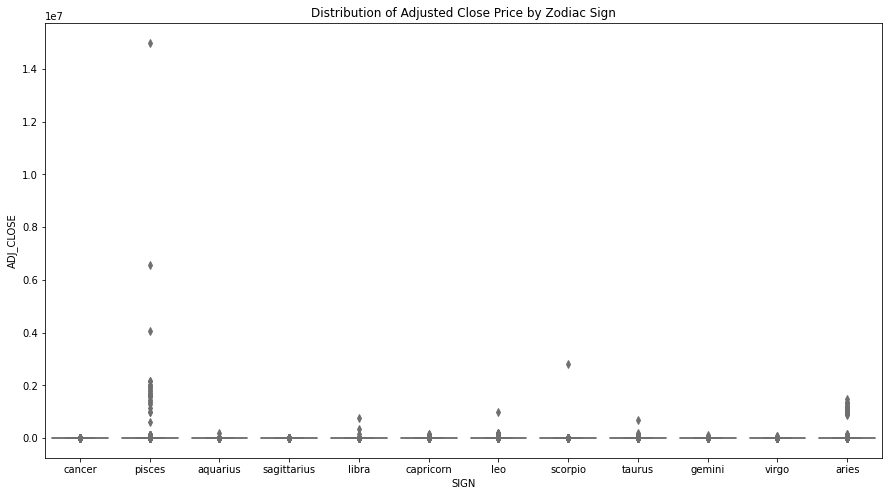

In [23]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=db, x='SIGN', y='ADJ_CLOSE', palette="pastel")
plt.title('Distribution of Adjusted Close Price by Zodiac Sign')
plt.show()

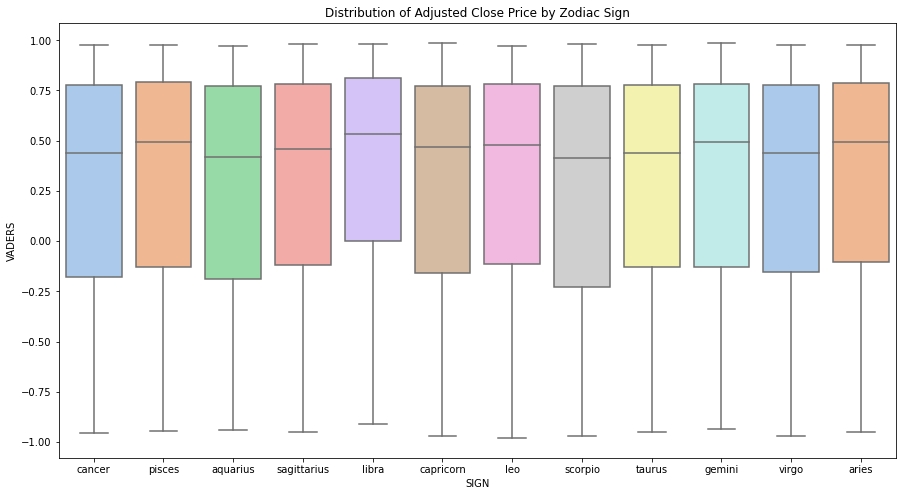

In [6]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=db, x='SIGN', y='VADERS', palette="pastel")
plt.title('Distribution of Adjusted Close Price by Zodiac Sign')
plt.show()

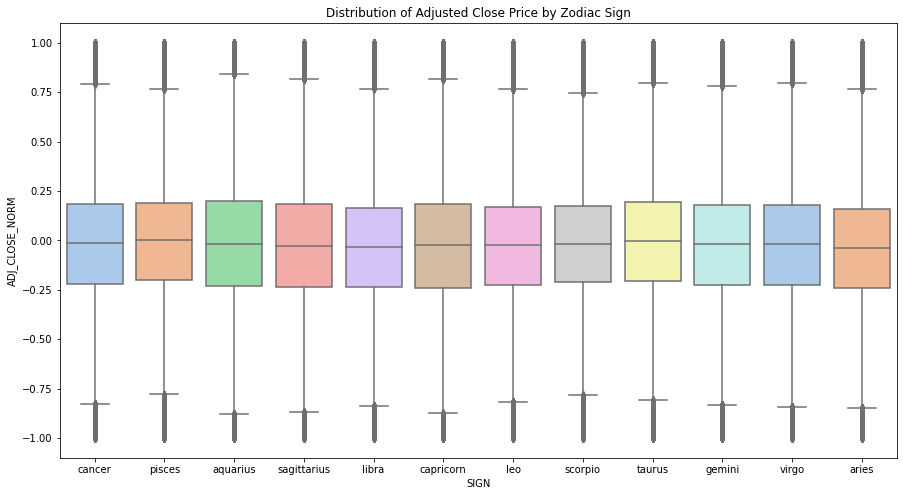

In [7]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=db, x='SIGN', y='ADJ_CLOSE_NORM', palette="pastel")
plt.title('Distribution of Adjusted Close Price by Zodiac Sign')
plt.show()

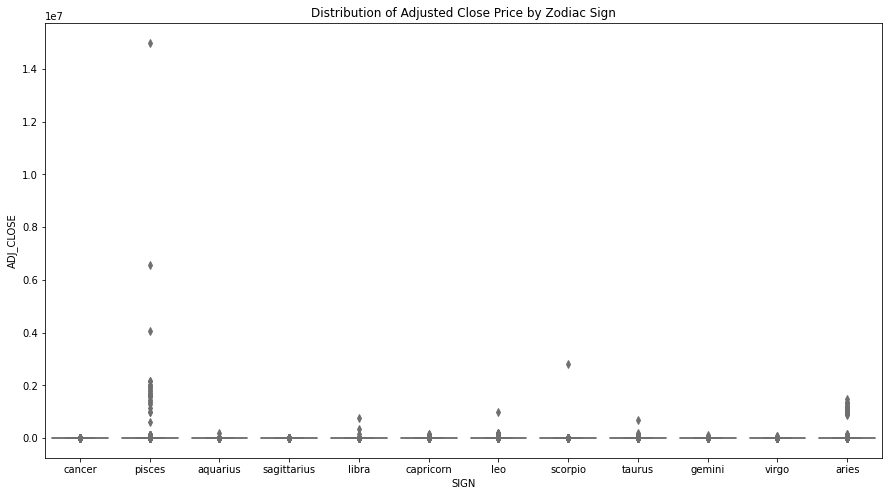

In [8]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=db, x='SIGN', y='ADJ_CLOSE', palette="pastel")
plt.title('Distribution of Adjusted Close Price by Zodiac Sign')
plt.show()

In [12]:
db['ROBERTA'].mean()

0.14015216295580799

In [10]:
db['DATE'].value_counts()

DATE
2016-12-08    5040
2016-12-07    5037
2016-12-05    5033
2016-11-30    5025
2016-12-12    5024
              ... 
2013-12-26    4111
2013-12-09    4110
2013-12-03    4106
2013-12-05    4105
2013-12-24    4066
Name: count, Length: 764, dtype: int64

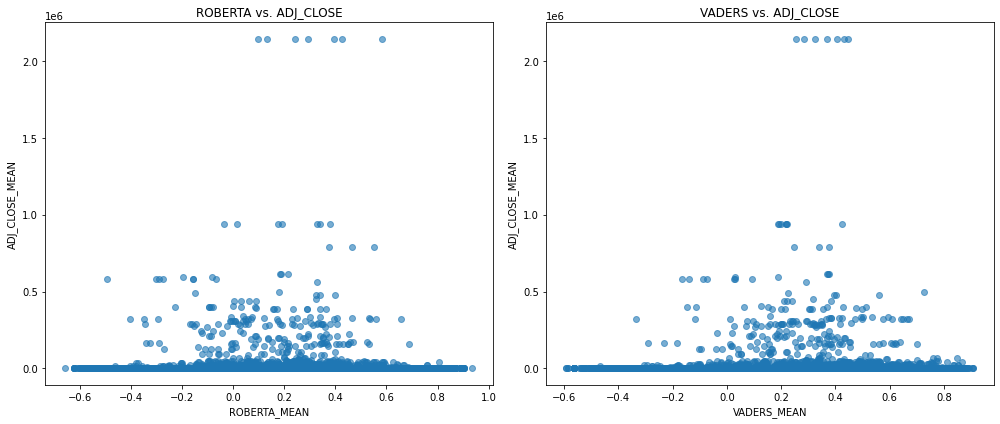

                ROBERTA_MEAN  VADERS_MEAN  ADJ_CLOSE_MEAN
ROBERTA_MEAN        1.000000     0.555642        0.000163
VADERS_MEAN         0.555642     1.000000       -0.001009
ADJ_CLOSE_MEAN      0.000163    -0.001009        1.000000


In [15]:
threshold = 0.1
filtered_data = db[(db['ROBERTA'].abs() > threshold) & (db['VADERS'].abs() > threshold)]

# Rolling average (e.g., 7 days)
rolling_window = 7
filtered_data['ADJ_CLOSE_MEAN'] = filtered_data['ADJ_CLOSE'].rolling(window=rolling_window).mean()
filtered_data['ROBERTA_MEAN'] = filtered_data['ROBERTA'].rolling(window=rolling_window).mean()
filtered_data['VADERS_MEAN'] = filtered_data['VADERS'].rolling(window=rolling_window).mean()

# Scatter plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(filtered_data['ROBERTA_MEAN'], filtered_data['ADJ_CLOSE_MEAN'], alpha=0.6)
plt.title('ROBERTA vs. ADJ_CLOSE')
plt.xlabel('ROBERTA_MEAN')
plt.ylabel('ADJ_CLOSE_MEAN')

plt.subplot(1, 2, 2)
plt.scatter(filtered_data['VADERS_MEAN'], filtered_data['ADJ_CLOSE_MEAN'], alpha=0.6)
plt.title('VADERS vs. ADJ_CLOSE')
plt.xlabel('VADERS_MEAN')
plt.ylabel('ADJ_CLOSE_MEAN')

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = filtered_data[['ROBERTA_MEAN', 'VADERS_MEAN', 'ADJ_CLOSE_MEAN']].corr()
print(correlation_matrix)

In [10]:
db.to_csv('dbdb.csv', sep=';')